# DATA 101 — Intro to Modeling (Session 1)

- Simple linear regression
- Visualizing fit
- $R^2$, $SS_{res}$, $SS_{tot}$
- Residual analysis patterns


## 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

print("Library versions:")
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("statsmodel:", sm.__version__)

Library versions:
numpy: 2.3.1
pandas: 2.3.1
matplotlib: 3.10.3
statsmodel: 0.14.5


## 1. Load `Advertising.csv` if available, else create a realistic synthetic dataset

In [2]:
import os

csv_path = './data/Advertising.csv'

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    # Generate a dataset similar to the classic ISLR Advertising dataset
    rng = np.random.default_rng(101)
    n = 200
    TV = rng.uniform(0, 300, n)              # thousands of dollars
    Radio = rng.uniform(0, 50, n)
    Newspaper = rng.uniform(0, 100, n)
    # true relationship with noise
    Sales = 3.0 + 0.045*TV + 0.18*Radio + 0.01*Newspaper + rng.normal(0, 1.2, n)
    df = pd.DataFrame({'TV': TV, 'Radio': Radio, 'Newspaper': Newspaper, 'Sales': Sales})
    df.to_csv(csv_path, index=False)

df.head()

,TV,Radio,Newspaper,Sales
0,283.059752,22.400382,13.046499,20.792160
1,107.826310,17.833197,17.377088,10.954803
2,235.441624,8.592322,25.762048,16.113905
3,177.383456,34.092156,92.782412,16.974606
4,88.298568,44.342255,80.859978,15.688330


## 2. Simple Linear Regression (Sales ~ TV) with `statsmodels`

In [3]:
X = sm.add_constant(df['TV'])  # add intercept
y = df['Sales']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     311.1
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           1.79e-42
Time:                        13:53:03   Log-Likelihood:                -503.85
No. Observations:                 200   AIC:                             1012.
Df Residuals:                     198   BIC:                             1018.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9141      0.430     18.391      0.0

## Interpretation:

---

### **Model summary**

Equation:
  Sales = 7.91 + 0.0435 * TV

---

### **1. Coefficients**

* **Intercept (7.91):**  
  When TV spending = 0, predicted sales ≈ **7.9 (k units)**    
  *Interpret cautiously* — we may not have data near TV = 0, so it’s an extrapolation.  

* **TV coefficient (0.0435):**  
  For every **$1,000 increase** in TV advertising, sales increase by **0.0435 (k units)**  
  → about **43.5 additional units** if the unit of Sales is in thousands.  

Both are **statistically significant (p < 0.001)**, meaning the relationship is very unlikely due to random chance.  

---

### **2. Model fit**

* **(R^2 = 0.611):**  
  61.1 % of the variation in Sales is explained by TV spending alone.  
  The rest (≈ 39 %) is due to other factors or randomness.   

* **Adjusted (R^2 = 0.609):**  
  Nearly the same, which is expected for one predictor. It corrects for number of variables.  

* **F-statistic = 311.1, p ≈ 1.8 × 10⁻⁴²:**  
  The model overall is statistically significant — TV ads provide predictive power.  

---

### **3. Residual diagnostics**

* **Durbin–Watson = 2.05:**  
  Residuals show no serial correlation (≈ 2 is ideal).  

* **Omnibus / Jarque–Bera tests (p ≈ 0.016):**  
  Slight deviation from normality in residuals, but not severe.  

---

### **4. Interpretation summary**

* Strong positive linear relationship between TV ad spending and sales.  
* Statistically reliable and moderately strong fit.
* Suitable as an **introductory predictive model**, but limited — only one predictor, moderate (R^2).

## 3. Visualizing the fit

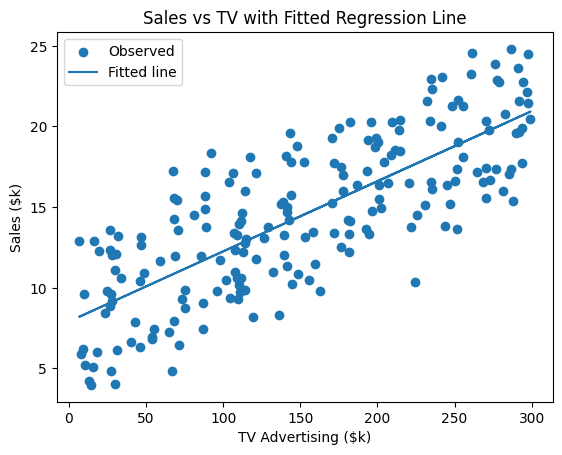

In [4]:
plt.figure()
plt.scatter(df['TV'], df['Sales'], label='Observed')
plt.plot(df['TV'], model.predict(X), label='Fitted line')
plt.xlabel("TV Advertising ($k)")
plt.ylabel("Sales ($k)")
plt.legend()
plt.title("Sales vs TV with Fitted Regression Line")
plt.show()

## 4. Understanding $R^2$ via sums of squares

In [5]:
y_pred = model.predict(X)
y_mean = y.mean()

SS_tot = np.sum((y - y_mean)**2)
SS_res = np.sum((y - y_pred)**2)
R2 = 1 - SS_res/SS_tot

print("SS_tot:", SS_tot)
print("SS_res:", SS_res)
print("R^2   :", R2)

SS_tot: 4644.220158978443
SS_res: 1806.1782937480025
R^2   : 0.6110911559056461


## 5. Residual analysis

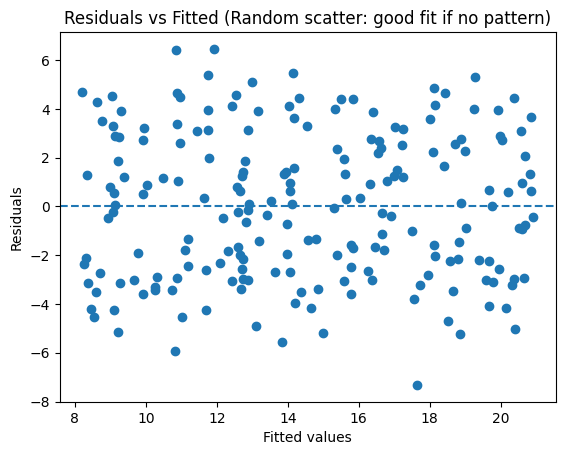

In [6]:
residuals = y - y_pred

# Residuals vs Fitted (good fit example)
plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Random scatter: good fit if no pattern)")
plt.show()

### 5.1 Funnel shape (heteroscedasticity)

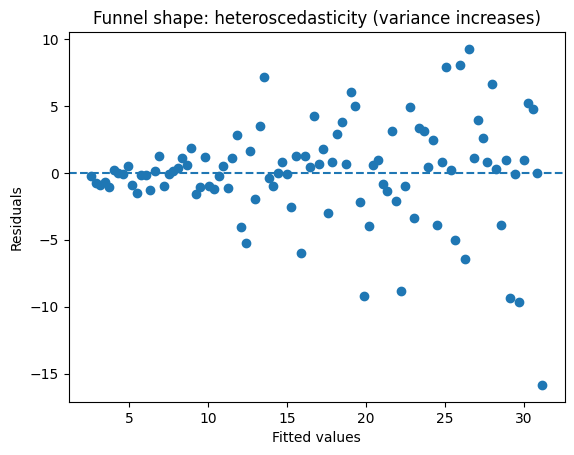

In [7]:
# Create heteroscedastic data where variance grows with TV
rng = np.random.default_rng(202)
x_f = np.linspace(0, 10, 100)
noise_f = rng.normal(0, 0.2 + 0.6*x_f, len(x_f))
y_f = 2 + 3*x_f + noise_f

lr_f = LinearRegression().fit(x_f.reshape(-1,1), y_f)
yhat_f = lr_f.predict(x_f.reshape(-1,1))
res_f = y_f - yhat_f

plt.figure()
plt.scatter(yhat_f, res_f)
plt.axhline(0, linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Funnel shape: heteroscedasticity (variance increases)")
plt.show()

### 5.2 Curved pattern (nonlinearity)

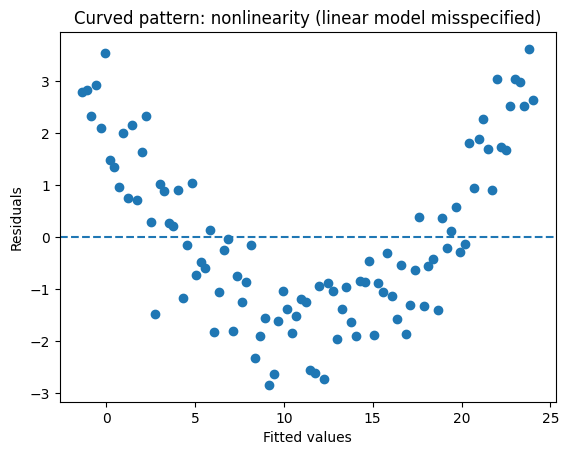

In [8]:
rng = np.random.default_rng(303)
x_c = np.linspace(0, 4, 100)
y_c = 2 + 1.5*x_c + 1.2*(x_c**2) + rng.normal(0, 0.7, len(x_c))  # true quadratic
lr_c = LinearRegression().fit(x_c.reshape(-1,1), y_c)            # fit linear on purpose
yhat_c = lr_c.predict(x_c.reshape(-1,1))
res_c = y_c - yhat_c

plt.figure()
plt.scatter(yhat_c, res_c)
plt.axhline(0, linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Curved pattern: nonlinearity (linear model misspecified)")
plt.show()

### 5.3 Outliers / high leverage

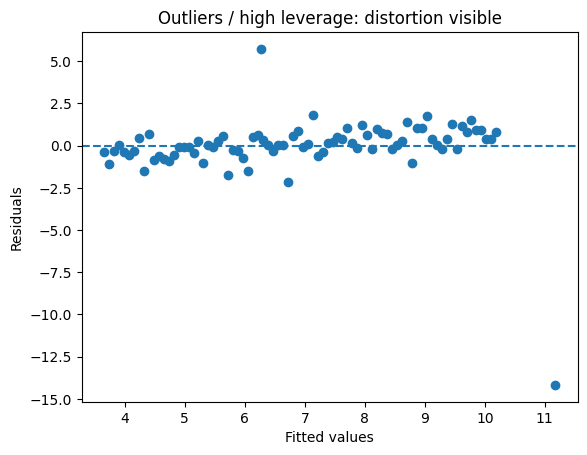

In [9]:
rng = np.random.default_rng(404)
x_o = np.linspace(0, 10, 80)
y_o = 3 + 0.8*x_o + rng.normal(0, 0.7, len(x_o))
# Add clear outliers
x_o = np.concatenate([x_o, [4.0, 11.5]])
y_o = np.concatenate([y_o, [12.0, -3.0]])

lr_o = LinearRegression().fit(x_o.reshape(-1,1), y_o)
yhat_o = lr_o.predict(x_o.reshape(-1,1))
res_o = y_o - yhat_o

plt.figure()
plt.scatter(yhat_o, res_o)
plt.axhline(0, linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Outliers / high leverage: distortion visible")
plt.show()

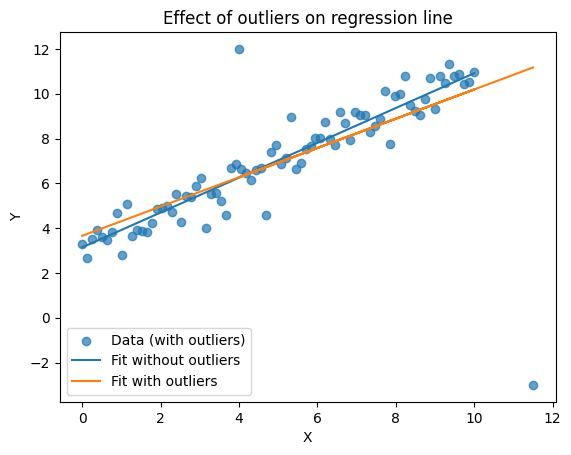

In [10]:
# Show distortion vs clean fit
x_clean = np.linspace(0, 10, 80)
y_clean = 3 + 0.8*x_clean + rng.normal(0, 0.7, len(x_clean))
m_clean = LinearRegression().fit(x_clean.reshape(-1,1), y_clean)
yhat_clean = m_clean.predict(x_clean.reshape(-1,1))

plt.figure()
plt.scatter(x_o, y_o, label='Data (with outliers)', alpha=0.7)
plt.plot(x_clean, yhat_clean, label='Fit without outliers')
plt.plot(x_o, yhat_o, label='Fit with outliers')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Effect of outliers on regression line")
plt.show()